## Project.15 Телеком: исследование оттока клиентов

    (yandex_practicum by student@pavel_matushevskiy, Volgograd 2022)

### Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.


### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Шаг.  Импорт библиотек и настроек

In [3]:
# блок импорта
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Подготовка моделей
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize, Normalizer
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

# Модели
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Метрики
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# CatBoost
from catboost import CatBoostClassifier, Pool, cv

import phik
from phik.report import plot_correlation_matrix
from phik import report

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

RANDOM_STATE = 190922

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Numpy        : 1.21.5


### План работы

1. Провести начальный обзор и общую подготовку данных. 
2. Сделать обьединение данных в 1 датасет; проверить типы и содержимое данных.  
3. Предобработка данных. Обработка пропусков, аномалий, выбросов.
2. Анализ данных (посмотреть зависимости признаков между собой и таргетом, вузализация данных, предварительные выводы)
3. Подготовка данных для обучения модели (выделение таргета, балансировка классов, отбор значимых признаков, скалирование, кодирование признаков)
4. Работа с моделями и подбор параметров (в т.ч. оптимизация для лучшего решения, fine tune моделей)
5. Выбор лучшей итоговой модели с применением cross-validation и формирование выводов.

###  Шаг 1. Начальный обзор и общая подготовка данных.

In [4]:
# Подгрузим наши файлы с данными:
try:
    contract_data = pd.read_csv('/datasets/contract.csv')
    internet_data = pd.read_csv('/datasets/internet.csv')
    personal_data = pd.read_csv('/datasets/personal.csv')
    phone_data = pd.read_csv('/datasets/phone.csv')
except:
    contract_data = pd.read_csv('datasets/contract.csv')
    internet_data = pd.read_csv('datasets/internet.csv')
    personal_data = pd.read_csv('datasets/personal.csv')
    phone_data = pd.read_csv('datasets/phone.csv')

In [5]:
# Посмотрим сводную информацию по всем датасетам:
data_set = [contract_data, internet_data, personal_data, phone_data]
for df in (data_set):
    print(df.info())
    print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-

У всех датасетов есть общий признак - "customerID".  
От него и будем отталкиваться.  
Чтобы не работать с каждым датасетом в отдельности, целесообразно обьединить их в 1.

### Шаг.2 Обьединение данных в 1 датасет, проверка типов и содержимое данных.

In [6]:
# соберем общий датасет из имеющихся данных:
df = contract_data.merge(personal_data, how='left', on='customerID').merge(
    internet_data, how='left', on='customerID').merge(phone_data,
                                                      how='left',
                                                      on='customerID')
df = df.set_index('customerID')
df.sample(20)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
8098-TDCBU,2016-08-01,No,Two year,No,Electronic check,25.25,1108.2,Female,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
9067-SQTNS,2016-06-01,No,One year,No,Bank transfer (automatic),20.60,926,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3508-VLHCZ,2014-03-01,No,Two year,Yes,Credit card (automatic),90.55,6239.05,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2091-MJTFX,2017-05-01,2019-11-01 00:00:00,Month-to-month,No,Credit card (automatic),51.20,1561.5,Female,0,Yes,Yes,DSL,No,No,No,Yes,Yes,Yes,NaN
9447-YPTBX,2015-12-01,No,One year,Yes,Bank transfer (automatic),19.85,943.1,Female,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2138-VFAPZ,2018-12-01,No,Two year,Yes,Mailed check,19.70,263.65,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
1926-QUZNN,2014-02-01,No,Two year,Yes,Bank transfer (automatic),25.25,1841.2,Female,0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
0956-SYCWG,2019-01-01,No,One year,No,Electronic check,19.65,244.8,Female,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6994-KERXL,2019-10-01,No,Month-to-month,Yes,Electronic check,55.90,238.5,Male,0,No,No,DSL,No,No,No,No,No,Yes,No


In [8]:
# уточним размерность датасета на выходе:
df.shape

(7043, 19)

In [9]:
# Хотя по этикету DS названия признаков не должны быть Upper,
# на ради единообразия и миропорядка переименуем:
df = df.rename(columns={'gender': 'Gender'})

In [10]:
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   Gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

<AxesSubplot:ylabel='customerID'>

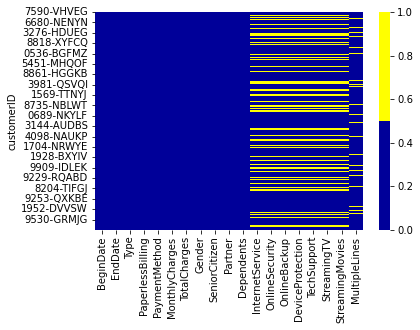

In [12]:
# визуализуем пропуски в датасете:
# определяем цвета
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00']
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))

Промежуточные выводы:   

В датасете есть пропуски как следствие обьединения датасетов. У нас есть несколько вариантов: 1. Дропнуть все пропуски и строить модель на остаточных данных. Хотя мы и потеряем 31% данных: - нужно проверить этот вариант и посмотреть на метрики модели. Вариант 2: попытаться заполнить пропуски. 


Займемся этим на следующем этапе проекта.

Некоторые признаки не корректны по типу данных:  

TotalCharges - нужно поменять на тип float,  

BeginDate, EndDate  - нужно поменять на тип datetime,  

остальные признаки можно не менять, мы их обработаем как категориальные признаки, декодируем через dummies.

In [13]:
# TotalCharges - поменяем на тип float: тут есть баг в данных:
df['TotalCharges'].isnull().sum()
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# Посмотрим, что вызывало ошибку
df[df['TotalCharges'].isnull()]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


Пропуски 'TotalCharges' обработаем в дальнейшем вместе с остальными пропусками.  

In [14]:
df.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen
count,7043.000000,7032.000000,7043.000000
mean,64.761692,2283.300441,0.162147
std,30.090047,2266.771362,0.368612
min,18.250000,18.800000,0.000000
25%,35.500000,401.450000,0.000000
50%,70.350000,1397.475000,0.000000
75%,89.850000,3794.737500,0.000000
max,118.750000,8684.800000,1.000000


Для лучшего анализа числовых признаков MonthlyCharges и TotalCharges далее мы используем графики (гистограмму и боксплот).

### Шаг 3. Предобработка данных. Обработка пропусков, аномалий, выбросов.

#### 3.1. Обработка пропусков

Обработка пропусков  

Несколько вариантов:  
1. Дропнуть все пропуски и строить модель на остаточных данных. Хотя мы и потеряем 31% данных: - нужно проверить этот вариант и посмотреть на метрики модели. df1 = df.dropna()  
2. заполнить пропуски.

#вариант #1:  

df = df.dropna()  

 Этот вариант на самом деле не самый плохой: учитывая что мы экономим кучу времени и сил, а результат всего на 1-1.5% хуже, чем при обработке пропусков.  
 


Вариант #2. заполнение пропусков (основной наш путь самурая):

In [15]:
# Признак "InternetService"
# Посмотрим на значения признака:
df["InternetService"].value_counts(normalize=True)

Fiber optic    0.561175
DSL            0.438825
Name: InternetService, dtype: float64

In [16]:
# Посчитаем кол-во пропусков:
df["InternetService"].isnull().sum()

1526

In [17]:
# Выделим пропуски в отдельную категорию:
df['InternetService'] = df['InternetService'].fillna('unknown')
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
unknown        1526
Name: InternetService, dtype: int64

In [18]:
# посмотрим на пропуски в других признаках:
df['OnlineSecurity'].value_counts()

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

In [19]:
df['OnlineBackup'].value_counts()

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

In [20]:
df['DeviceProtection'].value_counts()

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

In [21]:
df['TechSupport'].value_counts()

No     3473
Yes    2044
Name: TechSupport, dtype: int64

In [22]:
df['StreamingTV'].value_counts()

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

In [23]:
df['StreamingMovies'].value_counts()

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64

In [24]:
df['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

Как видим, признаки 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines' имеют значения YES/NO, поэтому можно попробовать пропуски причислить к значению "No".

In [25]:
# Заполним указанные пропуски значением "No":
features_none = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'MultipleLines'
]
df[features_none] = df[features_none].fillna('No')

In [26]:
# создадим новый признак, который будет нашим таргетом в дальнейшем:
df['target'] = (df['EndDate'] != 'No').astype('int')

Признаки EndDate и BeginDate в целом нам не нужны, но мы можем на их базе создать признак "Кол-во времени пользования услугами".   

Также помним, что дата окончания сбора инфо - 1 февраля 2020.

In [27]:
df.loc[(df['EndDate'] == 'No'), 'EndDate'] = '2020-02-01'
# преобразуем временные данные в соответстующий формат:
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
# Рассчитаем количество дней пользования услугами:
df['DaysOfUsage'] = (pd.to_datetime(df['EndDate']) -
                     pd.to_datetime(df['BeginDate'])).dt.days
df['DaysOfUsage'] = df['DaysOfUsage'].astype('int')

In [28]:
df['DaysOfUsage']

customerID
7590-VHVEG      31
5575-GNVDE    1036
3668-QPYBK      61
7795-CFOCW    1371
9237-HQITU      61
              ... 
6840-RESVB     730
2234-XADUH    2191
4801-JZAZL     337
8361-LTMKD     123
3186-AJIEK    2010
Name: DaysOfUsage, Length: 7043, dtype: int64

In [29]:
# Преобразуем значения признака Gender в числовые значения:
df['Gender'] = (df['Gender'] == 'Male').astype('int')

In [30]:
df.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,DaysOfUsage
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,Yes,...,DSL,No,Yes,No,No,No,No,No,0,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,1,0,No,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,0,No,...,DSL,Yes,Yes,No,No,No,No,No,1,61
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,1,0,No,...,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,No,...,Fiber optic,No,No,No,No,No,No,No,1,61


In [31]:
# заменим все значения в категориальный признаках (Yes/No) числовыми:
for column in df:
    tmp = df[column].unique()
    tmp.sort()
    if list(tmp) == ['No', 'Yes']:
        df[column] = (df[column] == 'Yes').astype('int')
        df[column] = df[column].astype('int')

In [32]:
df['TotalCharges'].unique()

array([  29.85, 1889.5 ,  108.15, ...,  346.45,  306.6 , 6844.5 ])

In [33]:
#  пропуски TotalCharges заполним нулями, т.к. это скорее всего O руб.:
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [34]:
# Удалим BeginDate и EndDate, они нам больше не понадобятся
del df['BeginDate'], df['EndDate']

In [35]:
#посмотрим итоговый результат:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   int64  
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   Gender            7043 non-null   int64  
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   int64  
 8   Dependents        7043 non-null   int64  
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   int64  
 11  OnlineBackup      7043 non-null   int64  
 12  DeviceProtection  7043 non-null   int64  
 13  TechSupport       7043 non-null   int64  
 14  StreamingTV       7043 non-null   int64  
 15  StreamingMovies   7043 non-null   int64  
 16  MultipleLines     7043 non-null 

In [36]:
df.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,DaysOfUsage
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,1,Electronic check,29.85,29.85,0,0,1,0,DSL,0,1,0,0,0,0,0,0,31
5575-GNVDE,One year,0,Mailed check,56.95,1889.50,1,0,0,0,DSL,1,0,1,0,0,0,0,0,1036
3668-QPYBK,Month-to-month,1,Mailed check,53.85,108.15,1,0,0,0,DSL,1,1,0,0,0,0,0,1,61
7795-CFOCW,One year,0,Bank transfer (automatic),42.30,1840.75,1,0,0,0,DSL,1,0,1,1,0,0,0,0,1371
9237-HQITU,Month-to-month,1,Electronic check,70.70,151.65,0,0,0,0,Fiber optic,0,0,0,0,0,0,0,1,61


Наши категориальные преобразуем  признаки с помощью OHE преобразуем перед построением модели, но сперва проведем анализ данных.

### Шаг 4. Анализ данных (посмотреть зависимости признаков между собой и таргетом, вузализация данных, предварительные выводы)

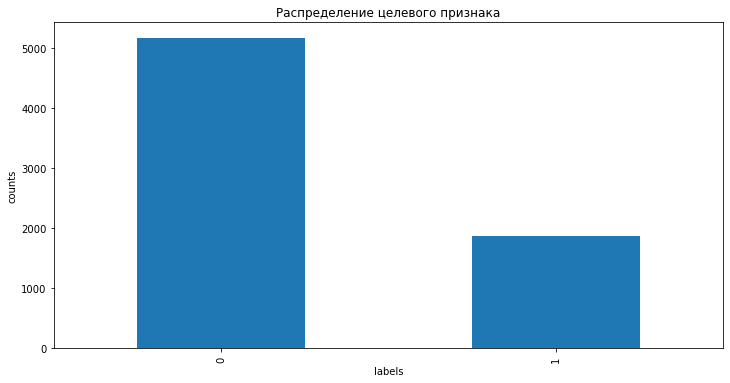

In [37]:
# Проверим баланс классов по target:
fig, ax = plt.subplots(1)
ax.set_title('Распределение целевого признака')
ax.set_xlabel('labels')
ax.set_ylabel('counts')
df['target'].value_counts().plot(kind='bar', figsize=(12, 6), ax=ax)
plt.show()

Налицо сильный дисбаланс классов, поэтому при построении модели будем это учитывать.
Будем использовать class_weigth непосредственно в модели и upsampling. 


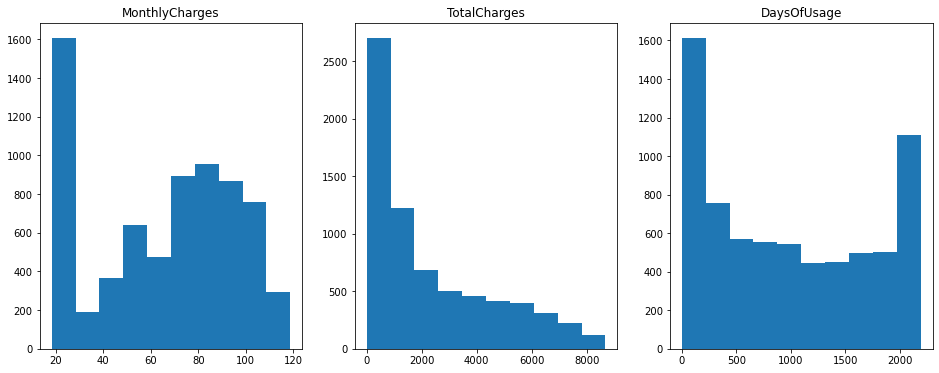

In [38]:
# Построим гистограмму для оценки распределения данных среди числовым признаков:
plt.figure(figsize=(16, 6))
numeric_names = ["MonthlyCharges", "TotalCharges", "DaysOfUsage"]
counter = 0
numeric_len = len(numeric_names)
for feature in numeric_names:
    counter += 1
    plt.subplot(1, numeric_len, counter)
    plt.hist(df[feature])
    plt.title(feature)

Много значений 0 в признаках, это связано с новыми клиентами, которые не успели еще "наработать" данных.

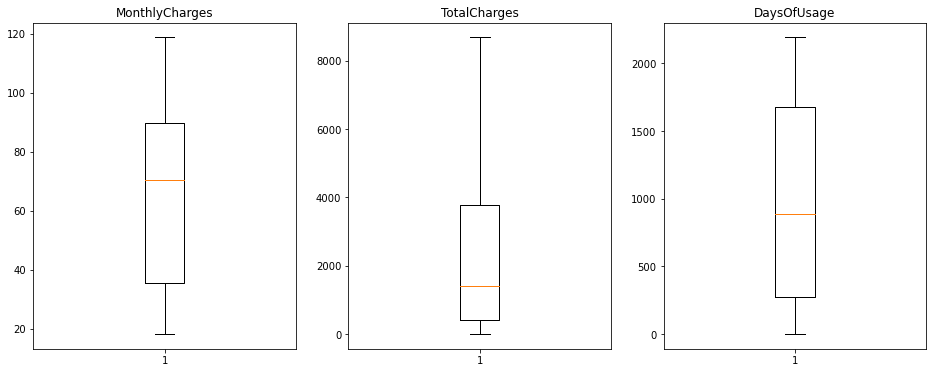

In [39]:
# Построим boxplot для оценки выбросов для числовых признаков:
plt.figure(figsize=(16, 6))
numeric_names = ["MonthlyCharges", "TotalCharges", "DaysOfUsage"]
counter = 0
numeric_len = len(numeric_names)
for feature in numeric_names:
    counter += 1
    plt.subplot(1, numeric_len, counter)
    plt.boxplot(df[feature])
    plt.title(feature)

Как видим, выбросов у числовых признаков нет. Это хорошо.  

Есть много значений 0, но это связано с  новыми  пользователями и их нулевыми показателями.

Посчитаем корреляцию Phik для признаков: она поможет выявить наличие  мультиколеарности и отобрать существенные признаки для обучения модели, удалить лишние признаки.

In [40]:
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'target', 'DaysOfUsage']


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,DaysOfUsage
Type,1.00,0.11,0.28,0.39,0.51,0.00,0.09,0.18,0.15,0.51,0.15,0.10,0.14,0.18,0.07,0.07,0.07,0.25,0.66
PaperlessBilling,0.11,1.00,0.37,0.47,0.21,0.00,0.24,0.01,0.17,0.23,0.00,0.20,0.16,0.06,0.34,0.33,0.25,0.30,0.00
PaymentMethod,0.28,0.37,1.00,0.40,0.35,0.00,0.29,0.24,0.22,0.32,0.26,0.28,0.31,0.27,0.38,0.38,0.34,0.45,0.38
MonthlyCharges,0.39,0.47,0.40,1.00,0.76,0.01,0.30,0.20,0.18,0.92,0.55,0.63,0.67,0.58,0.84,0.83,0.68,0.36,0.41
TotalCharges,0.51,0.21,0.35,0.76,1.00,0.00,0.15,0.42,0.12,0.51,0.55,0.65,0.67,0.57,0.66,0.67,0.61,0.28,0.84
Gender,0.00,0.00,0.00,0.01,0.00,1.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SeniorCitizen,0.09,0.24,0.29,0.30,0.15,0.00,1.00,0.02,0.32,0.16,0.06,0.10,0.09,0.09,0.16,0.19,0.22,0.23,0.03
Partner,0.18,0.01,0.24,0.20,0.42,0.00,0.02,1.00,0.65,0.00,0.22,0.22,0.24,0.19,0.19,0.18,0.22,0.23,0.49
Dependents,0.15,0.17,0.22,0.18,0.12,0.00,0.32,0.65,1.00,0.11,0.12,0.03,0.01,0.10,0.02,0.06,0.03,0.25,0.21
InternetService,0.51,0.23,0.32,0.92,0.51,0.00,0.16,0.00,0.11,1.00,0.24,0.23,0.23,0.24,0.27,0.27,0.23,0.20,0.02


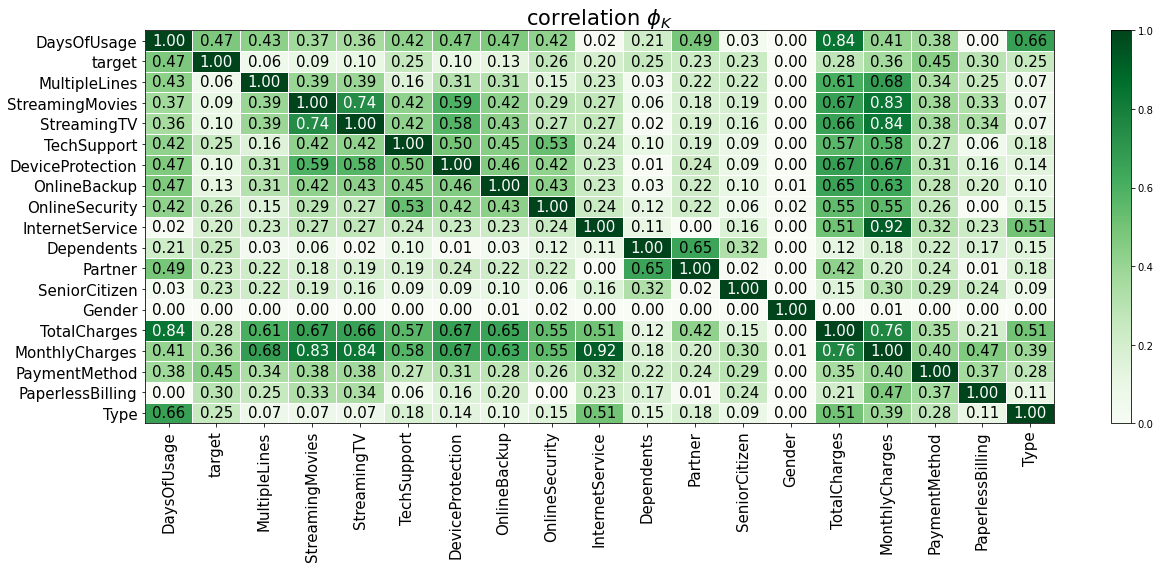

In [41]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0,
                        vmax=1,
                        color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1.5,
                        figsize=(18, 8))
plt.tight_layout()

Согласно таблицы мультиколлениарности есть между признаками:  
TotalCharges и DaysOfUsage (0.84),  
а также TotalCharges и  MonthlyCharges (0.76).   
В итоге - мы удаляем признак TotalCharges из данных.

расчет VIF (variance_inflation_factor)

In [42]:
# сделаем расчет VIF для оценки значимости признаков:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   int64  
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   Gender            7043 non-null   int64  
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   int64  
 8   Dependents        7043 non-null   int64  
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   int64  
 11  OnlineBackup      7043 non-null   int64  
 12  DeviceProtection  7043 non-null   int64  
 13  TechSupport       7043 non-null   int64  
 14  StreamingTV       7043 non-null   int64  
 15  StreamingMovies   7043 non-null   int64  
 16  MultipleLines     7043 non-null 

In [50]:
df_numeric = df._get_numeric_data()
df_numeric
vif = pd.Series([
    variance_inflation_factor(df_numeric.values, i)
    for i in range(1, df_numeric.shape[1])
],
                index=df_numeric.columns[1:])
print(vif)

MonthlyCharges      12.947824
TotalCharges        12.768229
Gender               1.897767
SeniorCitizen        1.357584
Partner              2.815806
Dependents           1.915219
OnlineSecurity       1.862791
OnlineBackup         2.182225
DeviceProtection     2.291049
TechSupport          1.932339
StreamingTV          2.903204
StreamingMovies      2.930394
MultipleLines        2.582410
target               1.835925
DaysOfUsage          8.771388
dtype: float64


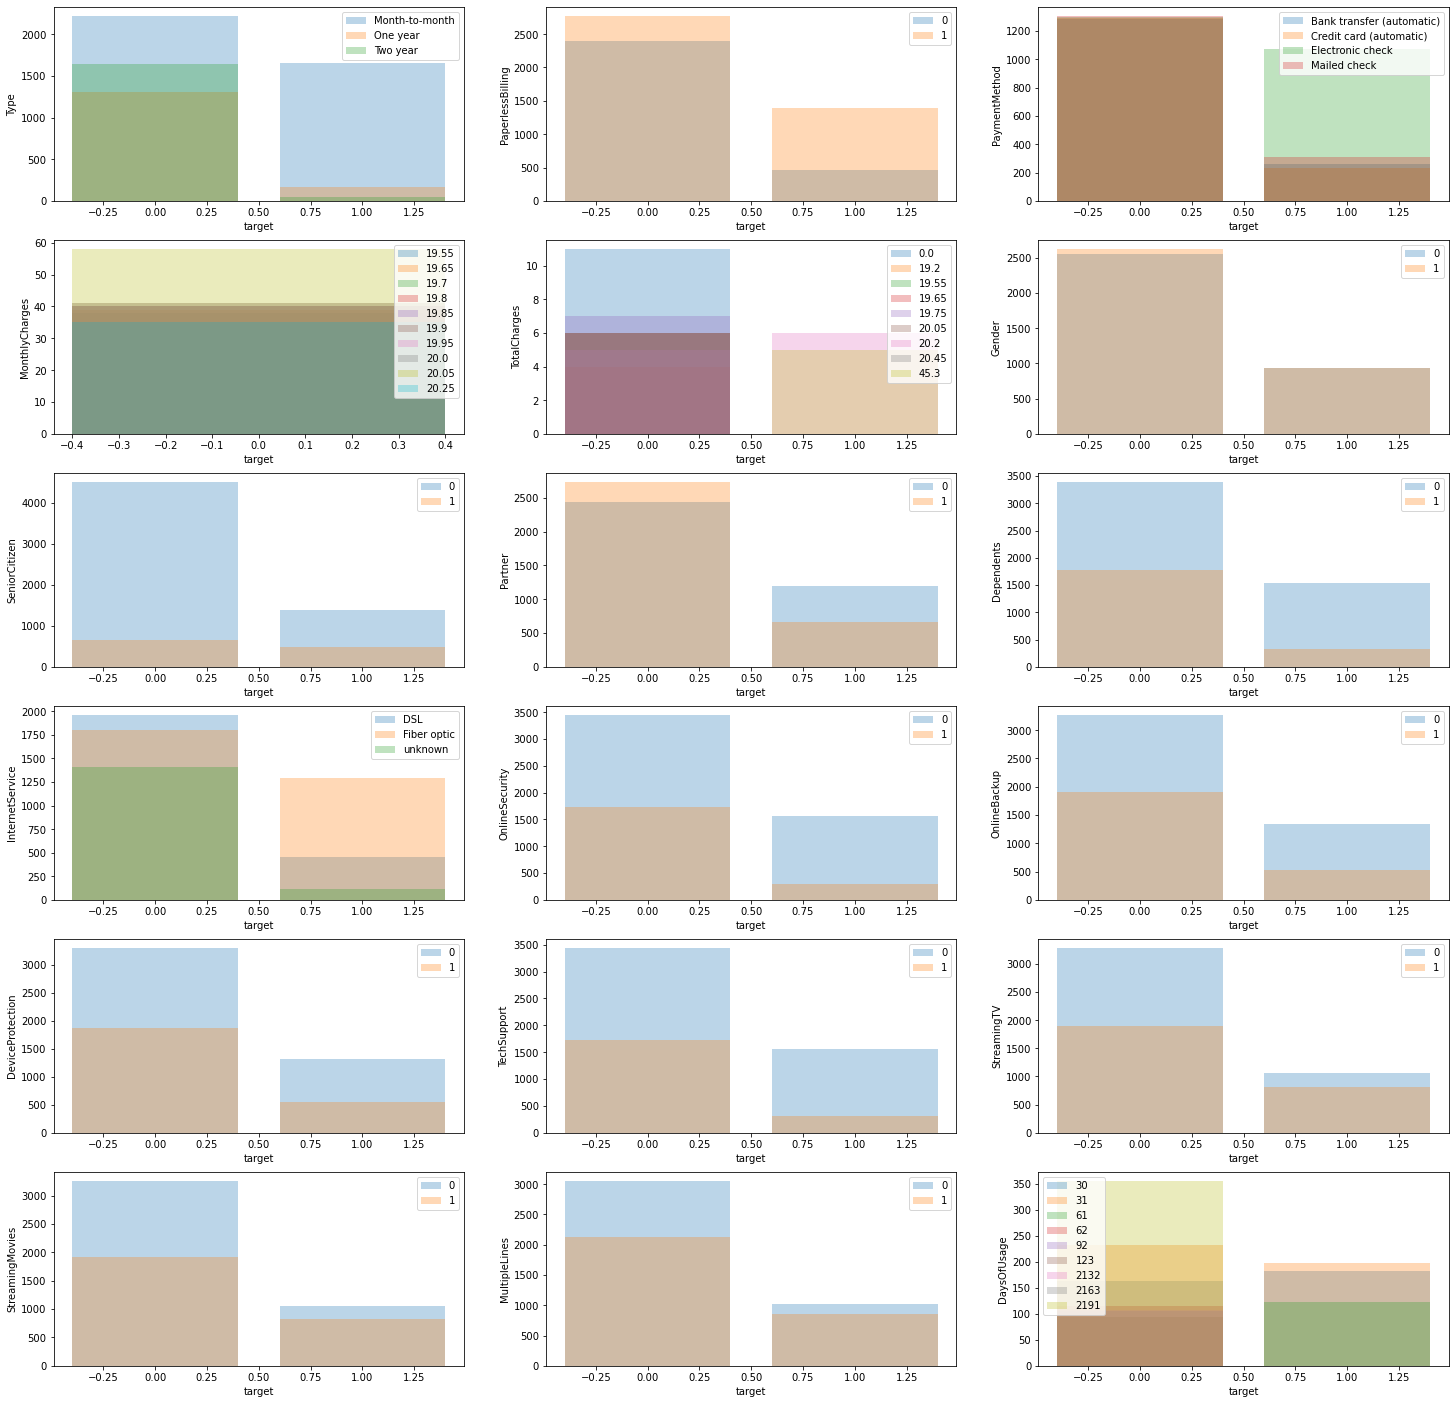

In [51]:
# Посмотрим на распределение признаков относительно нашего целевого target:
numeric_names = ["TotalCharges", "MonthlyCharges", "DaysOfUsage"]
target_name = 'target'
features_names = list(df.columns)
features_names.remove(target_name)
plt.figure(figsize=(25, 25))

number_cols = 3
n_rows = math.ceil(len(features_names) / number_cols)

counter = 0
for feature in features_names:
    counter += 1
    feature_values = set(df[feature])

    # У числовых групп может быть вагон значений, возьмем топ-10
    if len(feature_values) > 10:
        feature_values = df[feature].value_counts().index[:10]

    ax = plt.subplot(n_rows, number_cols, counter)

    df_temp = df.groupby([feature,
                          target_name])[target_name].count().nlargest(10)
    df_temp = df_temp.unstack()

    for column in df_temp.T.columns:
        ax.bar(df_temp.T.index, df_temp.T[column], alpha=0.3, label=column)

    plt.xlabel(target_name)
    plt.ylabel(feature)
    plt.legend()

In [52]:
# отберем для обучения только признаки с корреляцией >0.10:
phik_overview['target'].sort_values(ascending=False)

target              1.000000
DaysOfUsage         0.474001
PaymentMethod       0.449125
MonthlyCharges      0.360050
PaperlessBilling    0.295754
TotalCharges        0.278498
OnlineSecurity      0.264580
TechSupport         0.254615
Dependents          0.253936
Type                0.251639
SeniorCitizen       0.233432
Partner             0.232930
InternetService     0.196202
OnlineBackup        0.126973
DeviceProtection    0.101516
StreamingTV         0.096865
StreamingMovies     0.093923
MultipleLines       0.059581
Gender              0.000000
Name: target, dtype: float64

Оставим для обучения модели только следующие признаки c кореляцией >0.1: 
    
DaysOfUsage         0.474001  

PaymentMethod       0.449125  

MonthlyCharges      0.360050  

PaperlessBilling    0.295754   

OnlineSecurity      0.264580  

TechSupport         0.254615  

Dependents          0.253936  

Type                0.251639  

SeniorCitizen       0.233432  

Partner             0.232930  

InternetService     0.196202  

OnlineBackup        0.126973  

DeviceProtection    0.101516                              

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   int64  
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   Gender            7043 non-null   int64  
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   int64  
 8   Dependents        7043 non-null   int64  
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   int64  
 11  OnlineBackup      7043 non-null   int64  
 12  DeviceProtection  7043 non-null   int64  
 13  TechSupport       7043 non-null   int64  
 14  StreamingTV       7043 non-null   int64  
 15  StreamingMovies   7043 non-null   int64  
 16  MultipleLines     7043 non-null 

In [54]:
# соберем финальный датасет для обучения модели:
df_model = df[[
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'MonthlyCharges',
    'target',
    # 'TotalCharges',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',  # 'StreamingTV', 'StreamingMovies', 'MultipleLines',
    'DaysOfUsage'
]]

In [55]:
df_model.to_csv("df_model2")

In [56]:
df_model = pd.read_csv("df_model2")
#df_model = pd.read_csv("df_model_dropna")

### Шаг 5. Подготовка данных для обучения модели

In [57]:
features_names = [
    'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
    'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'DaysOfUsage'
]

# удалили 'MonthlyCharges', 'TotalCharges' - т.к. с ними хуже результат
#numeric_names = [ 'MonthlyCharges', 'TotalCharges', 'DaysOfUsage']
numeric_names = ['MonthlyCharges', 'DaysOfUsage']

df_features = df_model[features_names]
df_target = df_model['target']

# разделим на обучающие признаки и тестовые в соотношении 25%/75% по ТЗ:
features_train, features_test, target_train, target_test = train_test_split(
    df_features, df_target, test_size=0.25, random_state=RANDOM_STATE)

In [58]:
features_train.shape, features_test.shape, df_model.shape

((5282, 13), (1761, 13), (7043, 15))

Сделаем OHE декодирование для категориальных признаков:

In [7]:
features_train = pd.get_dummies(
    features_train, columns=['PaymentMethod', 'InternetService', 'Type'])
features_test = pd.get_dummies(
    features_test, columns=['PaymentMethod', 'InternetService', 'Type'])
features_train

,PaperlessBilling,MonthlyCharges,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,DaysOfUsage,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_unknown,Type_Month-to-month,Type_One year,Type_Two year
5755,1,96.50,1,1,0,1,0,1,0,457,0,0,1,0,0,1,0,1,0,0
4772,0,59.10,0,1,1,0,1,1,1,2102,1,0,0,0,1,0,0,0,1,0
5866,1,19.65,0,0,0,0,0,0,0,92,0,0,0,1,0,0,1,1,0,0
2468,1,48.55,0,1,0,0,1,0,0,122,0,0,1,0,1,0,0,1,0,0
2498,1,53.80,0,1,0,0,1,0,1,822,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1937,0,19.55,0,1,1,0,0,0,0,396,0,0,0,1,0,0,1,0,0,1
1513,1,25.80,1,0,0,0,0,0,0,30,0,0,0,1,1,0,0,1,0,0
1762,1,89.65,0,1,1,0,1,0,0,1067,1,0,0,0,0,1,0,1,0,0
4155,1,117.35,1,0,0,1,1,1,1,2191,0,1,0,0,0,1,0,0,0,1


In [8]:
# Проверим последовательность признаков в датасетах: в обоих совпадают.
print(features_train.columns)
print(features_test.columns)
print(list(features_test.columns) == list(features_train.columns))

Index(['PaperlessBilling', 'MonthlyCharges', 'SeniorCitizen', 'Partner',
       'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'DaysOfUsage', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_unknown', 'Type_Month-to-month', 'Type_One year',
       'Type_Two year'],
      dtype='object')
Index(['PaperlessBilling', 'MonthlyCharges', 'SeniorCitizen', 'Partner',
       'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'DaysOfUsage', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_unknown', 'Type_Month-to-month', 'Type_

In [9]:
# скалируем числовые признаки:
scaler = StandardScaler()
#scaler = Normalizer()
scaler.fit(features_train[numeric_names])
features_train[numeric_names] = scaler.transform(features_train[numeric_names])
features_test[numeric_names] = scaler.transform(features_test[numeric_names])
features_train[numeric_names].sample(10, random_state=RANDOM_STATE)

,MonthlyCharges,DaysOfUsage
6013,1.186040,0.728904
1491,-1.505547,-1.266675
6355,1.504650,1.461865
600,0.319820,-0.655428
4001,1.488056,0.525601
1626,-0.189623,-0.492251
2185,-0.337312,-0.331749
1369,-0.133203,0.037407
2812,1.298881,1.380276
6847,-0.297486,-0.573840


/Users/paulmatus/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


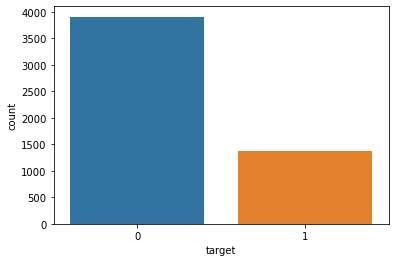

In [10]:
sns.countplot(target_train)
plt.show()

Балансировка классов через resample будет в конце (а также обучение лучшей модели на них).

### Обучение моделей. LogisticRegression model

In [11]:
# сделаем поиск лучших параметров:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
model = LogisticRegression(solver='lbfgs', penalty='l2')
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid.fit(features_train, target_train)
print(" Results from Grid Search for LogisticRegression:")
print("\n Лучшие параметры:\n", grid.best_params_)
print("\n Лучший результат auc_roc на кросс-валидации:\n", grid.best_score_)

 Results from Grid Search for LogisticRegression:

 Лучшие параметры:
 {'C': 0.1}

 Лучший результат auc_roc на кросс-валидации:
 0.8436644054331129


In [12]:
# посчитаем средний auc_roc по результатам cross-val:
grid.cv_results_["mean_test_score"].mean()

0.843215491379934

Результат roc_auc  у LogisticRegression неплохой, но мы попробуем улучшить на других моделях.

### Случайный лес model

Найдем поиск лучших параметров для RandomForest через GridSearchCV.

In [13]:
%%time

param_grid = {
    'max_depth': range(7, 12, 2),
    'min_samples_split': range(2, 12, 2),
    'min_samples_leaf': range(2, 12, 2),
    'n_estimators': range(200, 500, 100)
}

model = RandomForestClassifier(random_state=RANDOM_STATE)
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid.fit(features_train, target_train)
grid.best_params_

CPU times: user 6.82 s, sys: 77.5 ms, total: 6.9 s
Wall time: 6.91 s


{'max_depth': 7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [14]:
print(" Results from Grid Search for RandomForest:")
print("\n Лучшие параметры:\n", grid.best_params_)
print("\n Лучший результат auc_roc на кросс-валидации:\n", grid.best_score_)

 Results from Grid Search for RandomForest:

 Лучшие параметры:
 {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

 Лучший результат auc_roc на кросс-валидации:
 0.8595643646779184


In [15]:
# посчитаем средний auc_roc по результатам cross-val:
grid.cv_results_["mean_test_score"].mean()

0.8594188181231712

In [ ]:
# Зафиксируем лучшие найденные параметры:
# {'max_depth': 7,
# 'min_samples_leaf': 2,
# 'min_samples_split': 2,
# 'n_estimators': 300}

### CatBoost model

Найдем поиск лучших параметров для CatBoost через GridSearchCV.

In [16]:
feature_names = list(features_train.columns)
cat_features = list(set(feature_names) - set(numeric_names))

train_pool = Pool(data=features_train,
                  label=target_train,
                  cat_features=cat_features,
                  feature_names=feature_names)
test_pool = Pool(data=features_test,
                 label=target_test,
                 cat_features=cat_features,
                 feature_names=feature_names)

In [18]:
%%time

param_grids = {
    # из параметров оставил только поиск глубины обучения,
    #   остальные параметры модель сама хорошо подбирает:

    #  'iterations': [300, 500, 1000],
    #   'learning_rate': [0.01,0.05, 0.1],
    'depth': range(7, 12, 2),
    #   'l2_leaf_reg': range(2, 7, 2)
}

model = CatBoostClassifier(loss_function='Logloss',
                           eval_metric='AUC',
                           task_type="CPU",
                           verbose=0,
                           random_seed=RANDOM_STATE)
#model = CatBoostClassifier()
gs_result = GridSearchCV(estimator=model,
                         param_grid=param_grids,
                         cv=5,
                         scoring='roc_auc',
                         n_jobs=-1)
gs_result.fit(features_train, target_train)
gs_result.best_params_

CPU times: user 4.72 s, sys: 2.95 s, total: 7.67 s
Wall time: 41 s


{'depth': 7}

In [19]:
print(" Results from Grid Search for Catboost:")
print("\n Лучшие параметры:\n", gs_result.best_params_)
print("\n Лучший результат auc_roc на кросс-валидации:\n",
      gs_result.best_score_)

 Results from Grid Search for Catboost:

 Лучшие параметры:
 {'depth': 7}

 Лучший результат auc_roc на кросс-валидации:
 0.9028025753670921


In [20]:
# посчитаем средний auc_roc по результатам cross-val:
gs_result.cv_results_["mean_test_score"].mean()

0.8917588133976725

In [81]:
# использование баланса классов как ни странно, не дало улучшения:
classes = np.unique(target_train)
weights = compute_class_weight(class_weight='balanced',
                               classes=classes,
                               y=target_train)
class_weights = dict(zip(classes, weights))

In [82]:
model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    task_type="CPU",
    # class_weights=class_weights,
    class_weights={
        0: 1,
        1: 1.5
    },
    verbose=0,
    random_seed=RANDOM_STATE)

gs_result = GridSearchCV(estimator=model,
                         param_grid=param_grids,
                         cv=5,
                         scoring='roc_auc',
                         n_jobs=-1)
gs_result.fit(features_train, target_train)
gs_result.best_params_

In [83]:
print(" Results from Grid Search for Catboost:")
print("\n Лучшие параметры:\n", gs_result.best_params_)
print("\n Лучший результат auc_roc на кросс-валидации:\n",
      gs_result.best_score_)

In [93]:
# best result
# построим модель  на лучших настройках и проверим на тестовых данных:
model = CatBoostClassifier(
    loss_function='Logloss',
    depth=7,
    eval_metric='AUC',
    iterations=1500,
    learning_rate=0.05,
    task_type="CPU",
    random_seed=RANDOM_STATE,  # class_weights = class_weights,
    thread_count=-1,
    verbose=0)
model.fit(train_pool,
          eval_set=[(features_test, target_test)],
          use_best_model=True)
predicted_test = model.predict(test_pool)
predict_true_probalities = model.predict_proba(test_pool)[:, 1]
print('Test roc_auc_score:',
      roc_auc_score(target_test, predict_true_probalities))
print('Test accuracy:', accuracy_score(target_test, predicted_test))
print('Test f1:', f1_score(target_test, predicted_test))
print("balanced accuracy:", balanced_accuracy_score(target_test,
                                                    predicted_test))

In [87]:
# построим модель с ручной балансировкой классов: class_weights ={0:1,1:1.5}
model = CatBoostClassifier(
    loss_function='Logloss',
    depth=7,
    l2_leaf_reg=3,
    eval_metric='AUC',
    iterations=400,
    learning_rate=0.05,
    task_type="CPU",
    random_seed=RANDOM_STATE,
    thread_count=-1,
    # class_weights=class_weights,
    class_weights={
        0: 1,
        1: 1.5
    },
    verbose=0)
model.fit(train_pool,
          eval_set=[(features_test, target_test)],
          use_best_model=True)
predicted_test = model.predict(test_pool)
predict_true_probalities = model.predict_proba(test_pool)[:, 1]
print('Test roc_auc_score:',
      roc_auc_score(target_test, predict_true_probalities))
print('Test accuracy:', accuracy_score(target_test, predicted_test))
print('Test f1:', f1_score(target_test, predicted_test))
print("balanced accuracy:", balanced_accuracy_score(target_test,
                                                    predicted_test))

Странно, но балансировка классов через class_weights не дало улучшений по метрикам.

In [28]:
# напишем функцию для расчета auc_roc и постройки графика:
def plot_roc_curve(target_test, predicted_test):
    fpr, tpr, thresholds = roc_curve(target_test, predicted_test)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

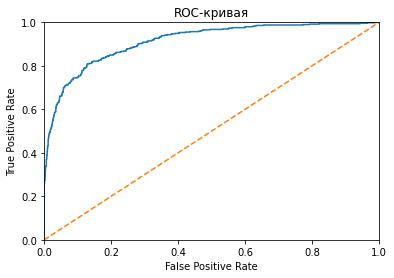

In [91]:
plot_roc_curve(target_test, predict_true_probalities)

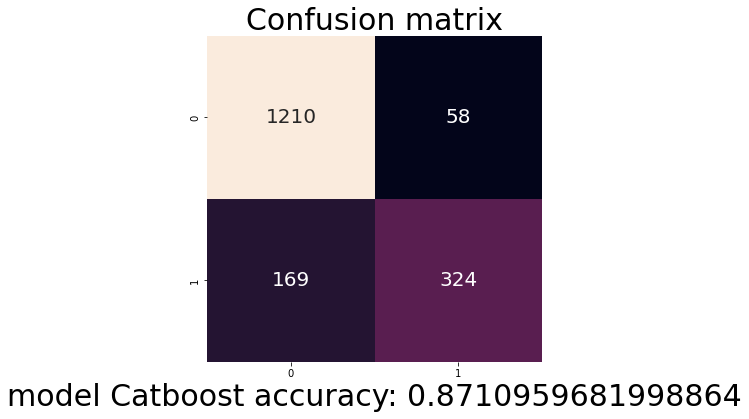

In [96]:
# нарисуем матрицу правильных ответов чтобы детальней оценить предсказания модели по таргету:
labels = [0, 1]
plt.subplots(figsize=(6, 6))
sns.heatmap(confusion_matrix(target_test, predicted_test),
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            fmt="1.0f",
            cbar=False,
            annot_kws={"size": 20})
plt.title("Confusion matrix", fontsize=30)
plt.xlabel(
    f"model Catboost аccuracy: {accuracy_score(target_test, predicted_test)}",
    fontsize=30)
plt.show()

### Балансировка классов через upsampling:

In [16]:
# уточним кол-во образцов по классам:
target_test.value_counts()

In [17]:
# сделаем upsampling через resample:

# concatenate our training data back together
data = pd.concat([features_train, target_train], axis=1)

# separate minority and majority classes
not_fraud = data[data['target'] == 0]
fraud = data[data['target'] == 1]

# upsample minority
fraud_upsampled = resample(
    fraud,
    replace=True,  # sample with replacement
    n_samples=len(not_fraud),  # match number in majority class
    random_state=RANDOM_STATE)  # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled['target'].value_counts()

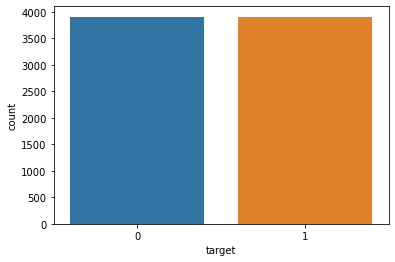

In [18]:
sns.countplot(upsampled['target'])
plt.show()

In [19]:
target_upsampled = upsampled['target']
features_upsampled = upsampled.drop(['target'], axis=1)

Обучим лучшую модель на upsampled данных:

In [20]:
%%time

param_grids = {
    # из параметров оставил только поиск глубины обучения,
    #   остальные параметры модель сама хорошо подбирает:

    #  'iterations': [300, 500, 1000],
    #   'learning_rate': [0.01,0.05, 0.1],
    'depth': range(7, 12, 2),
    #   'l2_leaf_reg': range(2, 7, 2)
}

model = CatBoostClassifier(loss_function='Logloss',
                           eval_metric='AUC',
                           task_type="CPU",
                           verbose=0,
                           random_seed=RANDOM_STATE)
#model = CatBoostClassifier()
gs_result = GridSearchCV(estimator=model,
                         param_grid=param_grids,
                         cv=5,
                         scoring='roc_auc',
                         n_jobs=-1)
gs_result.fit(features_upsampled, target_upsampled)
print(" Results from Grid Search for Catboost upsampled:")
print("\n Лучшие параметры:\n", gs_result.best_params_)
print("\n Лучший результат auc_roc на кросс-валидации:\n",
      gs_result.best_score_)

In [21]:
# посчитаем средний auc_roc по результатам cross-val:
gs_result.cv_results_["mean_test_score"].mean()

Как видим, с помощью upsampling нам удалось улучшить результат Catboost модели. Поэтому в качестве финальной модели возьмем Catboost  + upsampling данные для проверки на тестовых данных.

### Проверка лучшей модели на тестовых данных

In [22]:
target_upsampled = upsampled['target']
features_upsampled = upsampled.drop(['target'], axis=1)

In [23]:
feature_names = list(features_upsampled.columns)
cat_features = list(set(feature_names) - set(numeric_names))

train_pool = Pool(data=features_upsampled,
                  label=target_upsampled,
                  cat_features=cat_features,
                  feature_names=feature_names)
test_pool = Pool(data=features_test,
                 label=target_test,
                 cat_features=cat_features,
                 feature_names=feature_names)

In [24]:
model = CatBoostClassifier(
    loss_function='Logloss',
    depth=7,
    eval_metric='AUC',
    iterations=1500,  # learning_rate=0.05,
    task_type="CPU",
    random_seed=RANDOM_STATE,
    thread_count=-1,
    verbose=0)
model.fit(train_pool,
          eval_set=[(features_test, target_test)],
          use_best_model=True)
predicted_test = model.predict(test_pool)
predict_true_probalities = model.predict_proba(test_pool)[:, 1]
print('Test roc_auc_score:',
      roc_auc_score(target_test, predict_true_probalities))
print('Test accuracy:', accuracy_score(target_test, predicted_test))
print('Test f1:', f1_score(target_test, predicted_test))
print("balanced accuracy:", balanced_accuracy_score(target_test,
                                                    predicted_test))

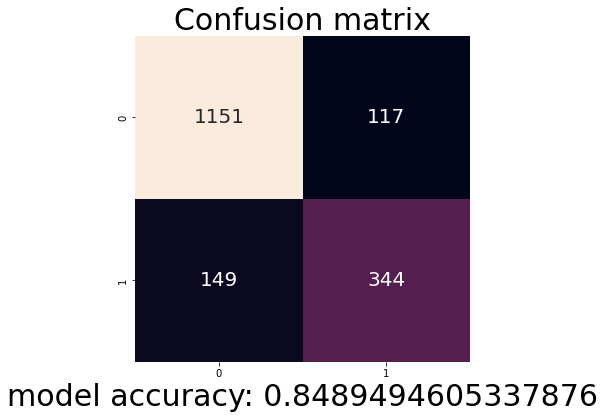

In [25]:
labels = [0, 1]
plt.subplots(figsize=(6, 6))
sns.heatmap(confusion_matrix(target_test, predicted_test),
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            fmt="1.0f",
            cbar=False,
            annot_kws={"size": 20})
plt.title("Confusion matrix", fontsize=30)
plt.xlabel(f"model аccuracy: {accuracy_score(target_test, predicted_test)}",
           fontsize=30)
plt.show()

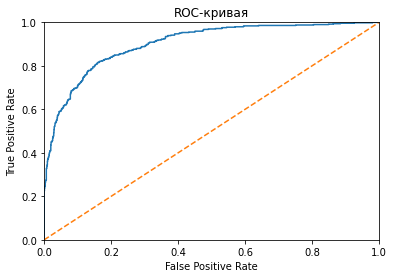

In [29]:
plot_roc_curve(target_test, predict_true_probalities)

Catboost показал лучшие результаты среди рассмотренных моделей с результатом:  

    Test roc_auc_score: 0.9028616722442268  
    Test accuracy: 0.8489494605337876  
    Test f1: 0.721174004192872  
    balanced accuracy: 0.8027487346510452   
    
Интересно, что балансировка классов по таркету не дала ожидаемого сильного улучшения метрики Auc_roc.  

Таким образом мы уложились в заданное тех.заданием требование Auc_roc > 0.88

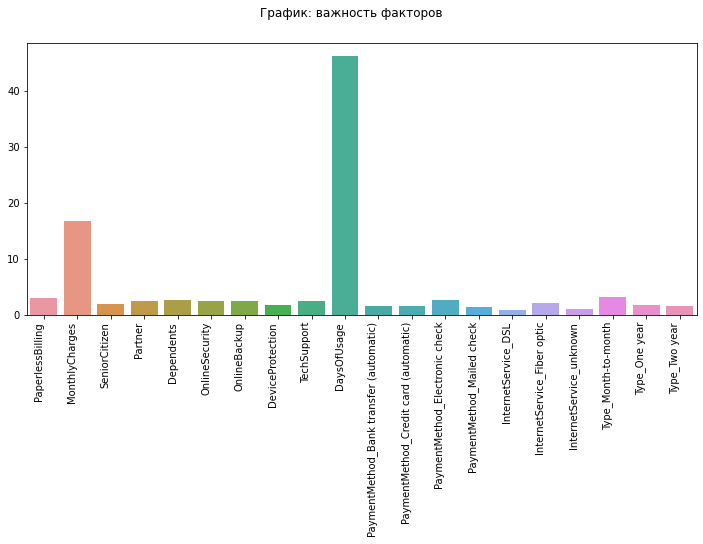

In [30]:
# добавим график значимости признаков:
fig, ax = plt.subplots(figsize=(12, 5))
fig.suptitle('График: важность факторов')
sns.barplot(y=model.feature_importances_, x=features_train.columns, ax=ax)
plt.xticks(rotation=90, horizontalalignment='right', fontweight='light')

Из графика видим, что самыми важными оказались: время пользования в днях (DaysOfUsage) и размер месячного платежка (MonthlyCharges).

### Итоговый отчет:

Мы проделали большую аналитическую работу в целом придерживаясь начального плана работы:  
    - провели обзор данных,  
    - сделали объединение данных в 1 датасет,  
    - проверили типы и содержимое данных,  
    - выполнили предобработку данных: решили проблему пропусков и проверили выбросы и дубликаты,  
    - изучили признаки между таргетом и собой, визуализировали,   
    - подготовили данные для обучения модели: отобрали значимые признаки, скалировали их,   выделили таргет, разделили на трайн\тест, обдумали проведение балансировки классов через class_weight и upsampling таркета, выполнили кодирование категориальных признаков,  
    - обучили 3 модели: логистическую регрессию, случайный лес и катбуст,  
    -основываясь на результатах среднего значения метрики *auc-roc* на кросс-валидации мы выбрали лучшую модель:  
    
        Логистическая регрессия	84.32%
        Случайный лес	85.94%
        CatBoost	89.18%
    
    
   - лучшей оказалась CatBoost, которая на тестовых данных показала следующие результаты:
   
    Test roc_auc_score: 0.9028616722442268  
    Test accuracy: 0.8489494605337876  
    Test f1: 0.721174004192872  
    Test balanced accuracy: 0.8027487346510452 
    
Параметры обучения модели CatBoost:    
       RANDOM_STATE = 190922, depth=7, iterations=1500,  learning_rate=0.05
    
    
Интересно, что балансировка классов по таркету не дала ожидаемого сильного улучшения метрики Auc_roc.

Из трудностей проекта хотелось бы отметить:
-этап отбора значимых признаков для обучения модели (пришлось использовать корреляцию, а также опытным путем эксперементировать с моделями, смотря на итоговый результат,
- также момент балансировки классов таргета - в итоге были проверены опытным путем разные варианты от class_weight (balanced, ручной подбор) до upsampling через resample.
    
Таким образом мы уложились в заданное тех.заданием требование Auc_roc > 0.88 и можно сказать успешно справились с задачей.
    